# Project description

You're working as an analyst for Zuber, a new ride-sharing company that's launching in Chicago. Your task is to find patterns in the available information. You want to understand passenger preferences and the impact of external factors on rides.

Working with a database, you'll analyze data from competitors and test a hypothesis about the impact of weather on ride frequency.

## Description of the data
A database with info on taxi rides in Chicago:

**`neighborhoods`** table: data on city neighborhoods
- `name`: name of the neighborhood
- `neighborhood_id`: neighborhood code
    
**`cabs`** table: data on taxis
- `cab_id`: vehicle code
- `vehicle_id`: the vehicle's technical ID
- `company_name`: the company that owns the vehicle

**`trips`** table: data on rides
`- trip_id`: ride code
- `cab_id`: code of the vehicle operating the ride
- `start_ts`: date and time of the beginning of the ride (time rounded to the hour)
- `end_ts`: date and time of the end of the ride (time rounded to the hour)
- `duration_seconds`: ride duration in seconds
- `distance_miles`: ride distance in miles
- `pickup_location_id`: pickup neighborhood code
- `dropoff_location_id`: dropoff neighborhood code

**`weather_records table`**: data on weather
- `record_id`: weather record code
- `ts`: record date and time (time rounded to the hour)
- `temperature`: temperature when the record was taken
- `description`: brief description of weather conditions, e.g. "light rain" or "scattered clouds"

## Table scheme

<img src="img/1.png" width=800, height=800>

# Instructions on completing the project

**Step 1. Write a code to parse the data on weather in Chicago in November 2017 from the website:**

https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html

**Step 2. Exploratory data analysis**

1. Find the number of taxi rides for each taxi company for November 15-16, 2017. Name the resulting field `trips_amount` and print it along with the `company_name` field. Sort the results by the `trips_amount` field in descending order.
2. Find the number of rides for every taxi company whose name contains the words *"Yellow"* or *"Blue"* for November 1-7, 2017. Name the resulting variable `trips_amount`. Group the results by the `company_name` field.
3. In November 2017, the most popular taxi companies were *Flash Cab* and *Taxi Affiliation Services*. Find the number of rides for these two companies and name the resulting variable `trips_amount`. Join the rides for all other companies in the group *"Other"*. Group the data by taxi company names. Name the field with taxi company names company. Sort the result in descending order by trips_amount.

**Step 3. Test the hypothesis that the duration of rides from the the Loop to O'Hare International Airport changes on rainy Saturdays**

1. For each hour, retrieve the weather condition records from the `weather_records` table. Using the `CASE` operator, break all hours into two groups: *"Bad"* if the description field contains the words *"rain"* or *"storm"*, and *"Good"* for others. Name the resulting field `weather_conditions`. The final table must include two fields: date and hour (`ts`) and `weather_conditions`.
2. Retrieve from the trips table all the rides that started in the *Loop* (`neighborhood_id: 50`) and ended at *O'Hare* (`neighborhood_id: 63`) on a Saturday. Get the weather conditions for each ride. Use the method you applied in the previous task. Also retrieve the duration of each ride. Ignore rides for which data on weather conditions is not available.

**Step 4. Exploratory data analysis (Python)**

In addition to the data you retrieved in the previous tasks, you've been given a second file. You now have these two CSVs:

`project_sql_result_01.csv`. It contains the following data:
- `company_name`: taxi company name
- `trips_amount`: the number of rides for each taxi company on November 15-16, 2017.

`project_sql_result_04.csv`. It contains the following data:
- `dropoff_location_name`: Chicago neighborhoods where rides ended
- `average_trips`: the average number of rides that ended in each neighborhood in November 2017.

For these two datasets you now need to:
- import the files
- study the data they contain
- make sure the data types are correct
- identify the top 10 neighborhoods in terms of drop-offs
- make graphs: taxi companies and number of rides, top 10 neighborhoods by number of dropoffs
- draw conclusions based on each graph and explain the results

**Step 5. Testing hypotheses (Python)**

`project_sql_result_07.csv` — the result of the last query. It contains data on rides from the Loop to O'Hare International Airport. 

Remember, these are the table's field values:
- `start_ts` — pickup date and time
- `weather_conditions` — weather conditions at the moment the ride started
- `duration_seconds` — ride duration in seconds

Test the hypothesis: **"The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."**

Set the significance level (alpha) value on your own.

**Explain**:
- how you formed the null and alternative hypotheses
- what criterion you used to test the hypotheses and why

# Project implementation

## Step 1. Write a code to parse the data on weather in Chicago in November 2017 from the website:
https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd

URL = 'https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html'
req = requests.get(URL)

# use `lxml` parser
soup = BeautifulSoup(req.text, 'lxml')

# retrieving the entire table
table = soup.find(attrs={'id': 'weather_records'})

# finding columns' names
col_names = []
for row in table.find_all('th'):
    col_names.append(row.text)

# finding the table's content
content=[]
for row in table.find_all('tr'):
    if not row.find_all('th'):
    # We need this condition to ignore the first row of the table, with headings
        content.append([element.text for element in row.find_all('td')])

# making a data frame out of it
weather_records = pd.DataFrame(content, columns=col_names).set_index('Date and time')
display(weather_records.head())

,Temperature,Description
Date and time,,
2017-11-01 00:00:00,276.150,broken clouds
2017-11-01 01:00:00,275.700,scattered clouds
2017-11-01 02:00:00,275.610,overcast clouds
2017-11-01 03:00:00,275.350,broken clouds
2017-11-01 04:00:00,275.240,broken clouds


## Step 2. Exploratory data analysis (SQL)

### Task 1
Find the number of taxi rides for each taxi company for `November 15-16, 2017`. Name the resulting field `trips_amount` and print it along with the `company_name` field. Sort the results by the `trips_amount` field in descending order.

```SQLite
SELECT
    cabs.company_name AS name,
    COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    INNER JOIN trips ON cabs.cab_id = trips.cab_id
WHERE
    CAST(trips.start_ts AS date) BETWEEN '2017-11-15' AND '2017-11-16'
GROUP BY
    cabs.company_name
ORDER BY
    trips_amount DESC
```
<img src="img/2.png" width=600, height=600>

### Task 2
Find the number of rides for every taxi company whose name contains the words `"Yellow"` or `"Blue"` for `November 1-7, 2017`. Name the resulting variable `trips_amount`. Group the results by the `company_name` field.

```SQLite
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    INNER JOIN trips ON cabs.cab_id = trips.cab_id
WHERE
    CAST(trips.start_ts AS date) BETWEEN '2017-11-1' AND '2017-11-7'
    AND cabs.company_name LIKE '%Yellow%'
GROUP BY
    cabs.company_name
UNION
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    INNER JOIN trips ON cabs.cab_id = trips.cab_id
WHERE
    CAST(trips.start_ts AS date) BETWEEN '2017-11-1' AND '2017-11-7'
    AND cabs.company_name LIKE '%Blue%'
GROUP BY
    cabs.company_name
```
<img src="img/3.png" width=600, height=600>

### Task 3

For November 1-7, 2017, the most popular taxi companies were `Flash Cab` and `Taxi Affiliation Services`. Find the number of rides for these two companies and name the resulting variable trips_amount. Join the rides for all other companies in the group `"Other"`. Group the data by taxi company names. Name the field with taxi company names company. Sort the result in descending order by `trips_amount`.

```SQLite
SELECT
    cabs.company_name AS company,
    COUNT(trips.trip_id) AS trips_amount
FROM
    cabs
    INNER JOIN trips ON cabs.cab_id = trips.cab_id
WHERE 
    CAST(trips.start_ts AS date) BETWEEN '2017-11-1' AND '2017-11-7'
    AND cabs.company_name IN('Flash Cab', 'Taxi Affiliation Services')
GROUP BY
    cabs.company_name
    
UNION ALL

SELECT
    'Other' AS company,
    SUM(SUBQ.trips_amount) AS trips_amount
FROM
    (SELECT
        cabs.company_name AS company,
        COUNT(trips.trip_id) AS trips_amount
    FROM
        cabs
        INNER JOIN trips ON cabs.cab_id = trips.cab_id
    WHERE 
        CAST(trips.start_ts AS date) BETWEEN '2017-11-1' AND '2017-11-7'
        AND cabs.company_name NOT IN('Flash Cab', 'Taxi Affiliation Services')
    GROUP BY
        cabs.company_name) AS SUBQ

ORDER BY 
    trips_amount DESC
```

<img src="img/4.png" width=600, height=600>

## Step 3. Test the hypothesis that the duration of rides from the the Loop to O'Hare International Airport changes on rainy Saturdays

### Task 1

For each hour, retrieve the weather condition records from the `weather_records` table. Using the `CASE` operator, break all hours into two groups: *"Bad"* if the description field contains the words *"rain"* or *"storm"*, and *"Good"* for others. Name the resulting field `weather_conditions`. The final table must include two fields: date and hour (`ts`) and `weather_conditions`.

```SQLite
SELECT
    ts,
    CASE WHEN description LIKE '%rain%' THEN 'Bad'
    WHEN description LIKE '%storm%' THEN 'Bad'
    ELSE 'Good' END AS weather_conditions
FROM 
    weather_records
```

<img src="img/5.png" width=600, height=600>

### Task 2
Retrieve from the trips table all the rides that started in the *Loop* (`neighborhood_id: 50`) and ended at *O'Hare* (`neighborhood_id: 63`) on a Saturday. Get the weather conditions for each ride. Use the method you applied in the previous task. Also retrieve the duration of each ride. Ignore rides for which data on weather conditions is not available.

Sort by trip_id.

```SQLite
SELECT
    trips.start_ts,
    CASE WHEN weather_records.description LIKE '%rain%' THEN 'Bad'
    WHEN weather_records.description LIKE '%storm%' THEN 'Bad'
    ELSE 'Good' END AS weather_conditions,
    trips.duration_seconds
FROM
    trips
    INNER JOIN weather_records ON trips.start_ts = weather_records.ts
WHERE
    trips.pickup_location_id = 50 AND EXTRACT(DOW FROM trips.start_ts) = 6 AND trips.dropoff_location_id = 63 
    AND weather_records.description IS NOT NULL
ORDER BY
    trip_id
```

<img src="img/6.png" width=600, height=600>

## Step 4. Exploratory data analysis (Python)

### Importing necessary libraries, loading and preparing the datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import plotly.express as px
import warnings
import plotly.io as pio


#pyo.init_notebook_mode()
pio.renderers.default = "svg"
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
try:
    rides_df = pd.read_csv('datasets\project_sql_result_01.csv')
    neighbr_df = pd.read_csv('datasets\project_sql_result_04.csv')
    weather_df = pd.read_csv('datasets\project_sql_result_07.csv')
except:
    print('Something went wrong!')

### Working on the `rides_df` dataset

In [4]:
# Looking at the dataset
rides_df.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [5]:
# Getting info about the dataset
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [6]:
rides_df.trips_amount = rides_df.trips_amount.astype('int16')

In [7]:
# Searching the missing values
rides_df.isna().sum()

company_name    0
trips_amount    0
dtype: int64

In [8]:
# Looking for duplicates
rides_df.duplicated().sum()

0

### Working on the `neighbr_df` dataset

In [9]:
# Looking at the dataset
neighbr_df.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [10]:
# Getting info about the dataset
neighbr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [11]:
neighbr_df.average_trips = neighbr_df.average_trips.astype('int16')

In [12]:
# Searching the missing values
neighbr_df.isna().sum()

dropoff_location_name    0
average_trips            0
dtype: int64

In [13]:
# Looking for duplicates
neighbr_df.duplicated().sum()

0

### Working on the `weather_df` dataset

In [14]:
# Looking at the dataset
weather_df.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [15]:
# Getting info about the dataset
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [16]:
# Searching the missing values
weather_df.isna().sum()

start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64

In [17]:
# Looking for duplicates
weather_df.duplicated().sum()

197

In [18]:
# closer look on the duplicated values
weather_df[weather_df.duplicated(keep=False)].sort_values(['start_ts', 'weather_conditions', 'duration_seconds']).head(6)

,start_ts,weather_conditions,duration_seconds
462,2017-11-04 05:00:00,Good,1200.0
541,2017-11-04 05:00:00,Good,1200.0
681,2017-11-04 06:00:00,Good,1267.0
682,2017-11-04 06:00:00,Good,1267.0
332,2017-11-04 07:00:00,Good,1140.0
979,2017-11-04 07:00:00,Good,1140.0


In [19]:
# deleting the duplicates
weather_df = weather_df.drop_duplicates(keep='first')
weather_df.duplicated().sum()

0

In [20]:
# transforming string to datetime
weather_df.start_ts = pd.to_datetime(weather_df.start_ts)

In [21]:
# chaning float64 to int16 the "duration_seconds" column
weather_df.duration_seconds = weather_df.duration_seconds.astype('int16')

In [22]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            871 non-null    datetime64[ns]
 1   weather_conditions  871 non-null    object        
 2   duration_seconds    871 non-null    int16         
dtypes: datetime64[ns](1), int16(1), object(1)
memory usage: 22.1+ KB


### Conclusion

The datasets have been successfully loaded and prepared for EDA. The data was mostly OK, despite some minor issues (e.g. improper dtype, some duplicates, etc.). Datasets didn't contain any missing values, columns' names have been written correctly.

### Exploratory data analysis (EDA)

#### Top-10 companies by the amount of trips

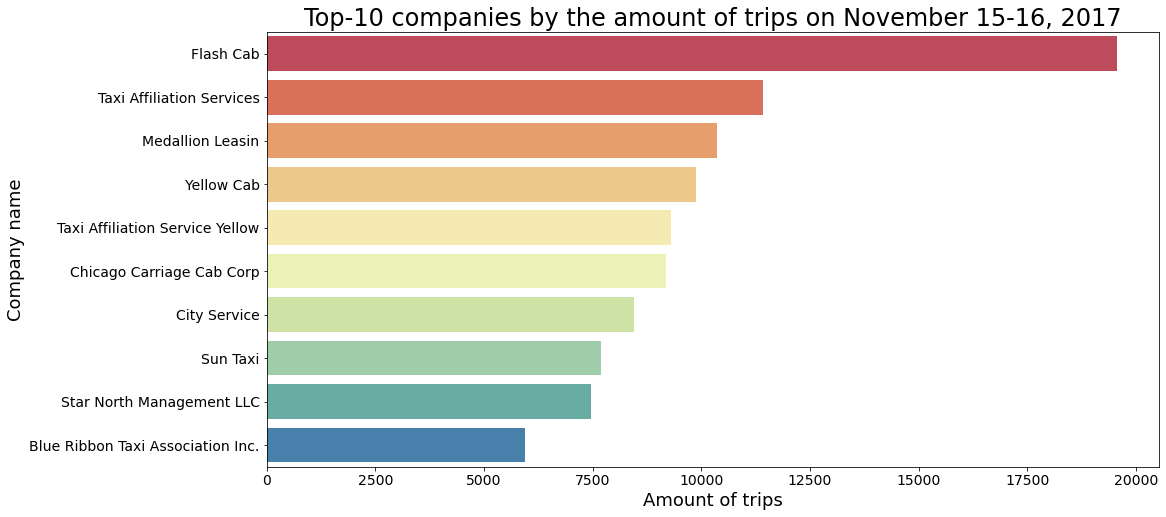

In [23]:
rides_data = rides_df.sort_values('trips_amount', ascending=False).head(10)
plt.figure(figsize=(16,8))
sns.barplot(y='company_name', x='trips_amount', data=rides_data, palette='Spectral')
plt.title('Top-10 companies by the amount of trips on November 15-16, 2017', size=24)
plt.xlabel('Amount of trips', size=18)
plt.ylabel('Company name', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

#### Trips share by the companies

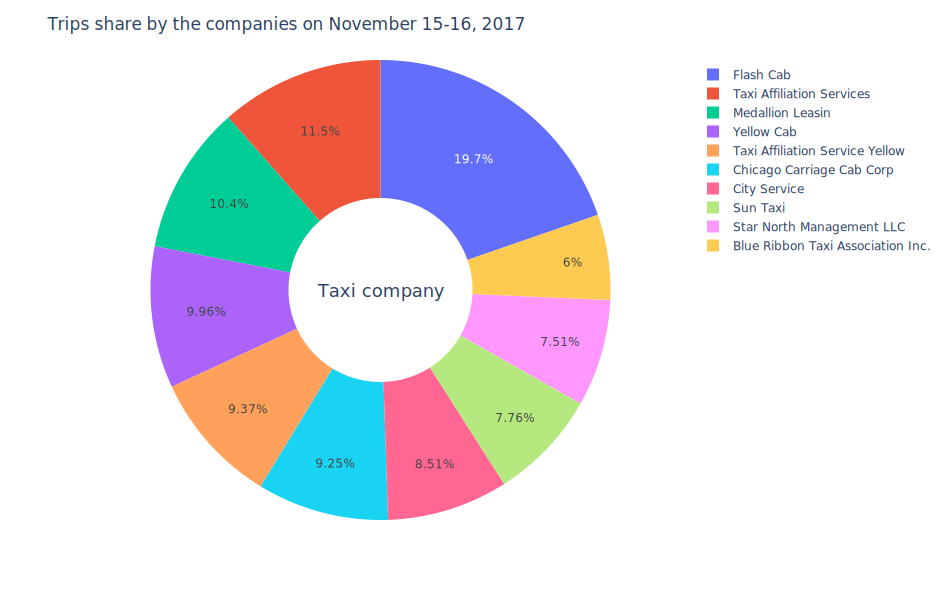

In [24]:
fig = px.pie(rides_data, values='trips_amount', names='company_name',
             hover_name='company_name', hole=0.4, width=950, height=600)
fig.update_layout(
    title_text="Trips share by the companies on November 15-16, 2017",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Taxi company', x=0.5, y=0.5, font_size=18, showarrow=False)])
fig.show()

#### Top-10 neighborhoods by the amount of trips

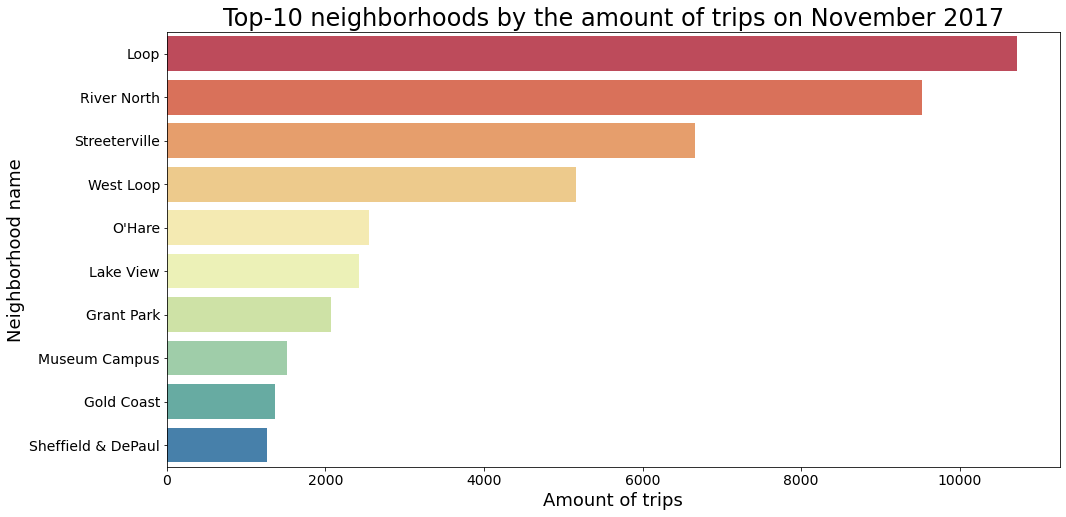

In [25]:
dropoff_data = neighbr_df.sort_values('average_trips', ascending=False).head(10)

plt.figure(figsize=(16,8))
sns.barplot(y='dropoff_location_name', x='average_trips', data=dropoff_data, palette='Spectral')
plt.title('Top-10 neighborhoods by the amount of trips on November 2017', size=24)
plt.xlabel('Amount of trips', size=18)
plt.ylabel('Neighborhood name', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

#### Trips share by the neighborhoods

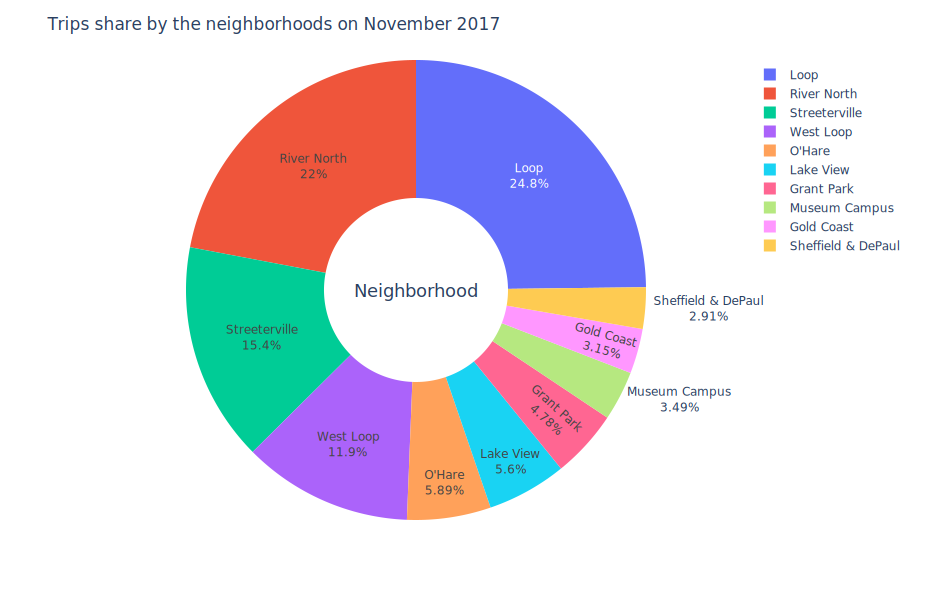

In [26]:
fig = px.pie(dropoff_data, values='average_trips', names='dropoff_location_name',
             hover_name='dropoff_location_name', hole=0.4, width=950, height=600)
fig.update_traces(text = dropoff_data.dropoff_location_name)
fig.update_layout(
    title_text="Trips share by the neighborhoods on November 2017",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Neighborhood', x=0.5, y=0.5, font_size=18, showarrow=False)])
fig.show()

#### The number of taxi orders per time of the day

In [27]:
# making a copy of the initial dataset
weather_df_modified = weather_df.copy()

#extracting hors and days of week
weather_df_modified['hour'] = weather_df_modified.start_ts.dt.hour

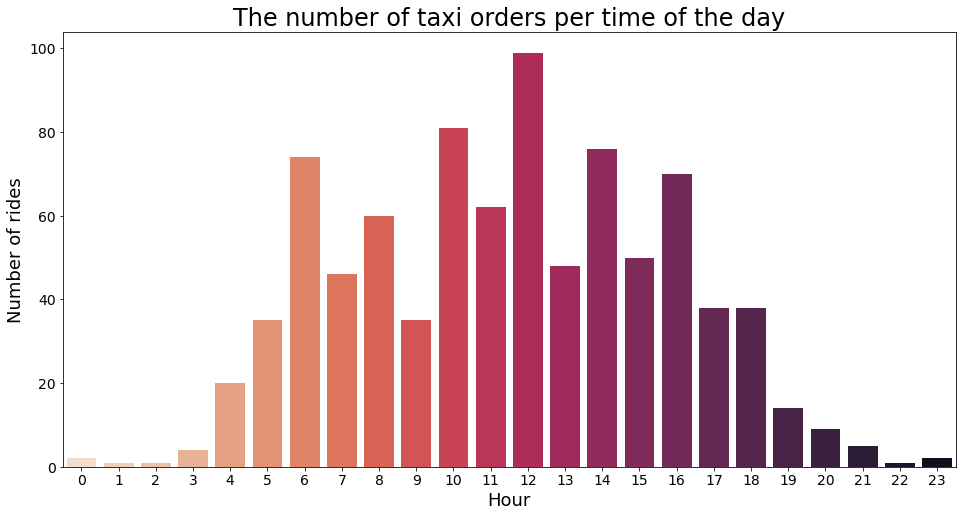

In [28]:
# counting the number of rides by each hor of the day
hours_data = weather_df_modified.groupby('hour')['start_ts'].count().to_frame()

# plotting the results
plt.figure(figsize=(16,8))
sns.barplot(data=hours_data, x=hours_data.index, y='start_ts', palette='rocket_r')
plt.title('The number of taxi orders per time of the day', size=24)
plt.xlabel('Hour', size=18)
plt.ylabel('Number of rides', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

#### Histogram of the rides' durations

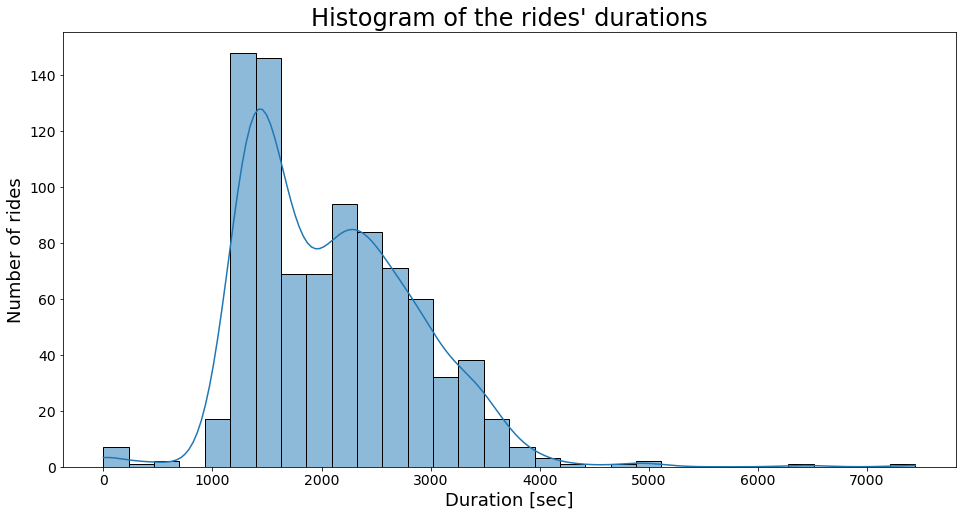

In [29]:
# plotting the results
plt.figure(figsize=(16,8))
sns.histplot(data=weather_df_modified, x='duration_seconds', kde=True)
plt.title("Histogram of the rides' durations", size=24)
plt.xlabel('Duration [sec]', size=18)
plt.ylabel('Number of rides', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

#### Trips share by the weather conditions

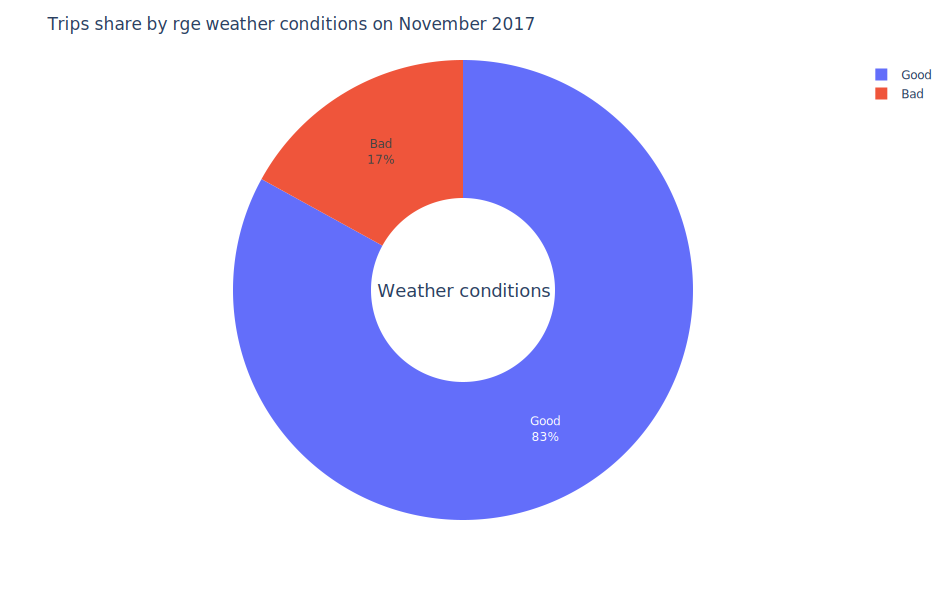

In [30]:
data_weather = weather_df_modified.groupby('weather_conditions').hour.count().to_frame()

fig = px.pie(data_weather, values='hour', names=data_weather.index, hover_name=data_weather.index,
             hole=0.4, width=950, height=600)
fig.update_traces(text = data_weather.index)
fig.update_layout(
    title_text="Trips share by rge weather conditions on November 2017",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Weather conditions', x=0.5, y=0.5, font_size=18, showarrow=False)])
fig.show()

### Conclusion

We have found top-10 companies by rides and their share % on November 16-17 2017. The top-1 company by rides (by far) is "Flash Cab" with a ride share of 19.7%. Other companies top-10 hold from 11% to 6% of the rideshare. Moreover, we have found the top-10 neighborhoods by drop-offs. Among them, Loop, River North, Streeterville, and West Loop are the most popular ones. The most popular neighborhood, Loop holds 24.8% of all drop-offs.

Furthermore, we have discovered that there are several hours in a day with most of the orders: 6 am, 10 am, 12 am (top time by the orders), 14 am, and 16 am. The ride duration histogram shows us a bimodal distribution with most of the rides about 1300 [sec] duration and 2200 [sec] duration. Finally, most of the rides (83%) take place in good weather, other 17% of the rides take place in bad weather.

## Step 5. Testing hypotheses (Python)

1. "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."

`Null hypothesis:` The average duration of rides from the Loop to O'Hare International Airport NOT changes on rainy Saturdays.

`Alternative hypothesis:` The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

As a generally accepted limit, 95% confidence is enough for us, hence `alpha=0.05`

### Visualization: histogram of the ride duration depending on the weather

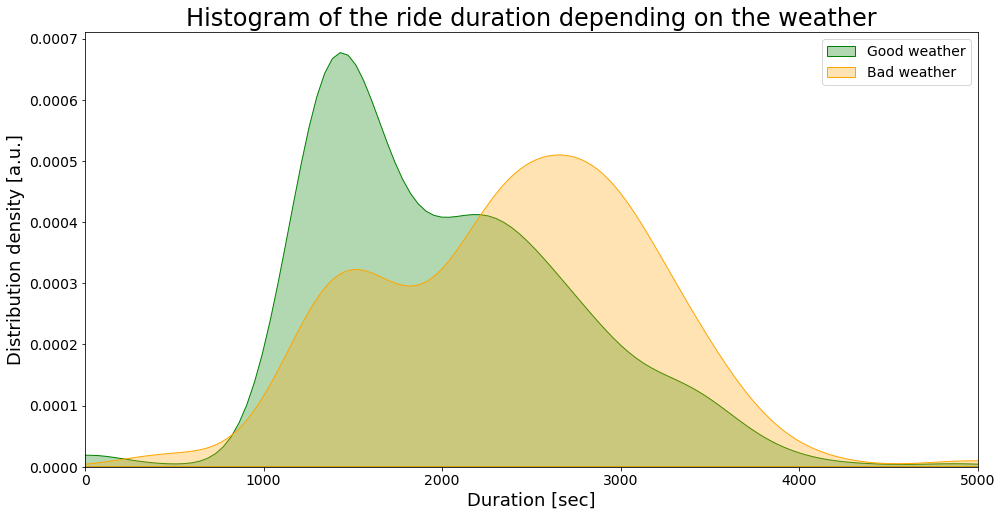

In [31]:
good_weather = weather_df[weather_df['weather_conditions'] == 'Good']['duration_seconds']
bad_weather = weather_df[weather_df['weather_conditions'] == 'Bad']['duration_seconds']

plt.figure(figsize=(16,8))

sns.distplot(good_weather, hist=False, kde_kws={'shade':True, 'color':'green', 'alpha':0.3}, label='Good weather')
sns.distplot(bad_weather, hist=False, kde_kws={'shade':True, 'color':'orange', 'alpha':0.3}, label='Bad weather')

plt.title("Histogram of the ride duration depending on the weather", size=24)
plt.xlabel('Duration [sec]', size=18)
plt.ylabel('Distribution density [a.u.]', size=18)
plt.xlim((0, 5000))
plt.legend(fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

In [32]:
var_good = round(np.var(good_weather, ddof=1))
var_bad = round(np.var(bad_weather, ddof=1))

print(f'Variance of ride durations during good weather = {var_good}')
print(f'Variance of ride durations during bad weather  = {var_bad}')

Variance of ride durations during good weather = 598217
Variance of ride durations during bad weather  = 564819


Let's compare the variance of the two populations. Variances of ride durations during good and bad weather are almost identical. We will use the `equal_var=True` parameter

### Checking the hypothesis

In [33]:
alpha = 0.05

results = st.ttest_ind(good_weather, bad_weather, equal_var=True)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Reject the null hypothesis")
    print(f'The average trip duration during good weather is: {int(good_weather.mean())} ± {round(good_weather.std())} [sec]')
    print(f'The average trip duration during bad weather is: {int(bad_weather.mean())} ± {round(bad_weather.std())} [sec]')
else:
    print("Failed to reject the null hypothesis")
    print(f'The average trip duration during good weather is: {int(good_weather.mean())} ± {good_weather.std()} [sec]')
    print(f'The average trip duration during bad weather is: {int(bad_weather.mean())} ± {bad_weather.std()} [sec]')

p-value:  7.397770692813604e-08
Reject the null hypothesis
The average trip duration during good weather is: 2032 ± 773 [sec]
The average trip duration during bad weather is: 2409 ± 752 [sec]


### Conclusion

As we can see, from the visualization, there are significant differences between trip durations during good and bad weather. Both show bimodal distributions but the durations during bad weather are shifted towards the higher values. The Student's t-test has proven that we have to reject the null-hypothesis, meaning that the average trip duration is different depending on the weather conditions. 

* The average trip duration during `good weather` is: 2032 ± 773 [sec] 
* The average trip duration during `bad weather` is: 2409 ± 752 [sec]